In [1]:
%matplotlib inline
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import joblib

from skimage import  morphology, filters, color, measure
from tensorflow import keras
size = (8,8)

In [2]:
sudoku = os.path.join(os.getcwd(), 'sudoku')
files = [os.path.splitext(x) for x in os.listdir(sudoku)]

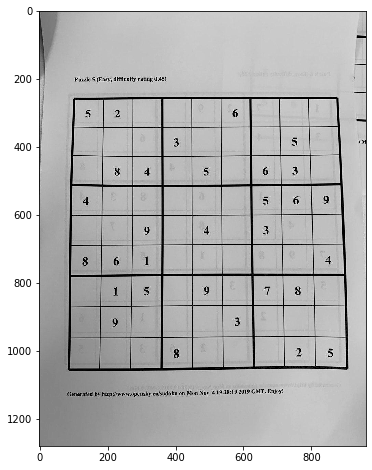

In [249]:
filename = 'davidf2-0'
basedir = os.path.join(os.getcwd(), 'sudoku')
img = cv2.imread(os.path.join(basedir, f'{filename}.png'), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=size)
plt.imshow(img, interpolation="none", cmap="gray")
plt.show()

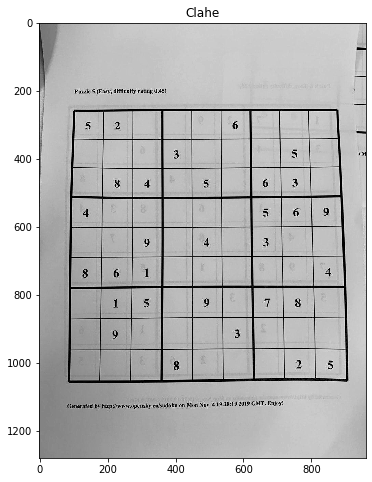

In [250]:
def contrast(img):
    clahe = cv2.createCLAHE(clipLimit=0.2, tileGridSize=(15,15))
    return clahe.apply(img)

img_clahe = contrast(img)
plt.figure(figsize=size)
plt.title('Clahe')
plt.imshow(img_clahe, interpolation="none", cmap="gray")
plt.show()

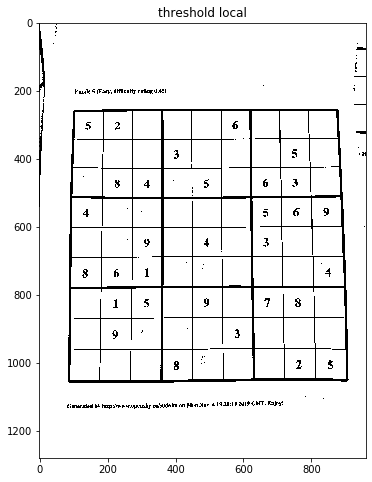

In [251]:
thresh = filters.threshold_local(img_clahe, 91, offset=18)
clean = img_clahe > thresh
plt.figure(figsize=size)
plt.title('threshold local')
plt.imshow(clean, interpolation="none", cmap="gray")
plt.show()

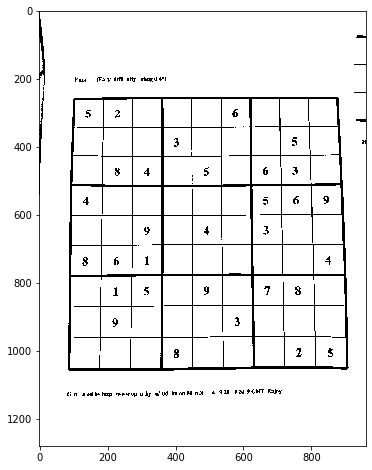

In [252]:
opening = ~morphology.remove_small_objects(~clean, min_size=50)
plt.figure(figsize=size)
plt.imshow(opening , interpolation="none", cmap="gray")
plt.show()



In [253]:
label = morphology.label(opening, connectivity=2)

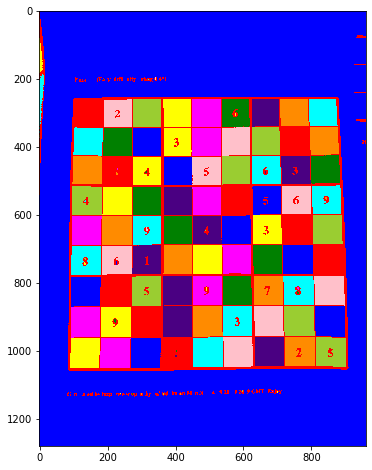

In [254]:
plt.figure(figsize=size)
plt.imshow(color.label2rgb(label), interpolation="none", cmap="gray")
plt.show()

In [255]:
def outliers(data):
    arr = []
    threshold=3
    mean = np.mean(data)
    std =np.std(data)

    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) <= threshold:
            arr.append(y)
    return arr

In [256]:
region = measure.regionprops(label)

In [257]:
areas = []

for obj in region:
    area = obj["area"]
    if area > 20 :
        areas.append(area)
    

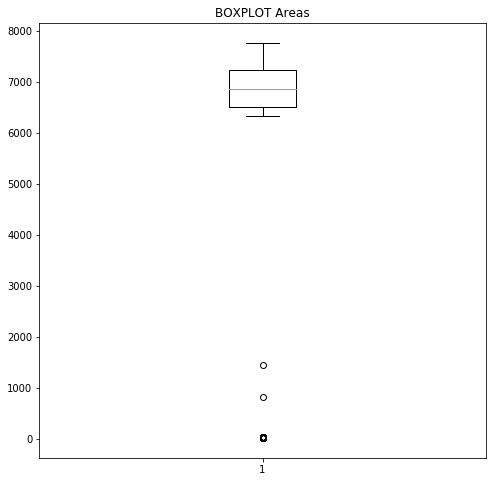

In [258]:
fig, ax = plt.subplots(figsize=size)
ax.set_title('BOXPLOT Areas')
ax.boxplot(outliers(areas))
plt.show()

In [259]:

def select(x):
    q1, q3= np.percentile(areas,[25,75])
    iqr = q3 - q1
    min_area = q1 -(1.5 * iqr) 
    max_area = q3 +(1.5 * iqr)
    
    return[min_area, max_area]

In [260]:
mask = np.zeros_like(opening)


min_area, max_area = select(areas)
boxes = {}
count = 0
for obj in region:
    area = obj["area"]
    
    if (area > min_area and area < max_area):
        bbox = obj.bbox
        mask[bbox[0]:bbox[2],bbox[1]:bbox[3]]|= (obj.filled_image)
        boxes[obj.label] = {}
        boxes[obj.label]['mask'] = (opening[bbox[0]:bbox[2],bbox[1]:bbox[3]] & (obj.filled_image))
        boxes[obj.label]['clean'] =  (boxes[obj.label]['mask'] | (~obj.filled_image))
        
        # Porcentagem de pixeis preenchidos em cada região
        boxes[obj.label]['filled'] = obj.area/obj.filled_area
        boxes[obj.label]['bbox'] = list(bbox)
        count +=1

        #         imagem |= (label == obj.label)
        

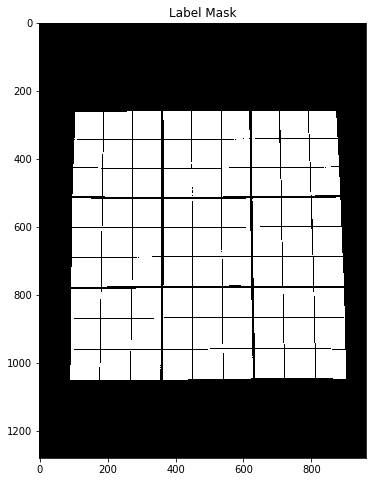

In [261]:
plt.figure(figsize=size)
plt.title("Label Mask")
plt.imshow(mask, interpolation="none", cmap="gray")
plt.show()

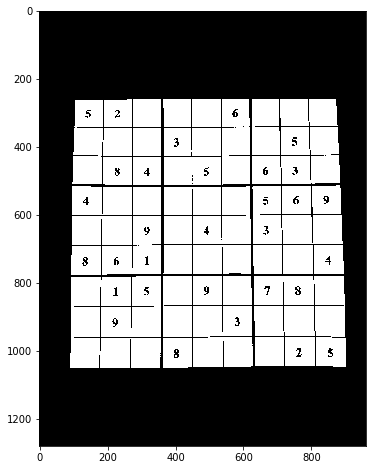

In [262]:
plt.figure(figsize=size)
plt.imshow(mask& opening, interpolation="none", cmap="gray")
plt.show()

In [263]:
points = [[x] + boxes[x]['bbox'] + [boxes[x]['filled']] for x in boxes.keys()]
points = sorted(points, key = lambda y: y[1])
chunks = np.asarray(points).reshape(9,9,6)

def sort(x):
    return sorted(x, key = lambda x: x[2])

matrixM = map(sort, chunks)
matrix = list(matrixM)

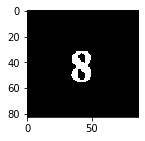

In [278]:
index = matrix[2][1][0].astype(int)
plt.figure(figsize=(2,2))
plt.imshow(~boxes[index]['clean'], interpolation="none", cmap="gray", vmin=0, vmax=1)
plt.show()

In [265]:
resized = cv2.resize((~boxes[index]['clean']).astype(np.uint8), (28,28))

In [266]:
model_cnn = keras.models.load_model('path_to_my_model.h5')

In [267]:
np.argmax(model_cnn.predict_proba(resized.reshape(1,28,28,1).astype(np.float16)))

1

In [268]:
resized.reshape(1,28,28,1).shape

(1, 28, 28, 1)

In [269]:
# count = 0
# x = []
# for i in range(len(matrix)):
#     line = ""
#     for j in range(len(matrix[i])):
#         index = matrix[i][j][0]
    
#         if boxes[index]['filled'] < 1:
#             count +=1
#             resized = cv2.resize((~boxes[index]['clean']).astype(np.uint8), (28,28))
#             pred = model_cnn.predict_proba(resized.reshape(1,28,28,1).astype(np.float16))
#             line += str(np.argmax(pred))
#         else:
#             line += "-"
#     x.append(line)

# print('count', count)

In [270]:
def empty(matrix, boxes):
    x = []
    for i in range(len(matrix)):
        line = ""
        for j in range(len(matrix[i])):
            index = matrix[i][j][0]
            if boxes[index]['filled'] < 1:
                line += "x"
            else:
                line += "-"
        x.append(line)
    return x

def predict(matrix, boxes, modelname):
    model_cnn = keras.models.load_model(modelname)
    x = []
    for i in range(len(matrix)):
        line = ""
        for j in range(len(matrix[i])):
            index = matrix[i][j][0]
            if boxes[index]['filled'] < 1:
                resized = cv2.resize((~boxes[index]['clean']).astype(np.uint8), (28,28))
                pred = model_cnn.predict_proba(resized.reshape(1,28,28,1).astype(np.float16))
                line += str(np.argmax(pred))
            else:
                line += "-"
        x.append(line)
    return x

    

In [271]:
# x = empty(matrix, boxes)
x = predict(matrix, boxes, 'path_to_my_model.h5')
x

['33---2---',
 '---3---3-',
 '-24-3-63-',
 '1-----363',
 '--2-1-3--',
 '661-----4',
 '-15-3-32-',
 '-3---3---',
 '---6---33']

In [272]:
def compare(x,y):
    for i in range(len(x)):
        for j in range(len(x[0])):
#             print(i,j)
            if(y[i][j] == "-" and x[i][j] != "-" or x[i][j] == "-" and y[i][j] != "-"):
                print(f'Errado {i},{j}')

In [273]:
with open(os.path.join(basedir,f'{filename}.txt')) as file:
    y = file.read().split()

In [274]:
compare(x,y)

In [275]:
y

['52---6---',
 '---3---5-',
 '-84-5-63-',
 '4-----569',
 '--9-4-3--',
 '861-----4',
 '-15-9-78-',
 '-9---3---',
 '---8---25']

In [276]:
x

['33---2---',
 '---3---3-',
 '-24-3-63-',
 '1-----363',
 '--2-1-3--',
 '661-----4',
 '-15-3-32-',
 '-3---3---',
 '---6---33']